In [1]:
import os
import torch
import pickle
from datetime import datetime, timedelta

import gym
import bayes_opt
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, Dataset
from torch.distributions.multivariate_normal import MultivariateNormal

from pushing.rl import load_from_path
from stitching.rl import (
    PolicyCollection,
    StateActionFunction,
    PopTart,
    LatentMapping,
    LatentWrapped,
    ReplayBuffer,
    soft_update,
    Policy)

## Create an array of policies to gather data from

In [2]:
def get_envs(base_path):
    envs = PolicyCollection()

    for folder in sorted(os.listdir(base_path)):
        if not os.path.isdir(os.path.join(base_path, folder)):
            continue
        agent_id = int(folder[-3:])
        path = os.path.join(base_path, folder)
        envs.append(*load_from_path(path))
        
    return envs
    
base_path = '../pushing/trained_agents/'
envs = get_envs('../pushing/trained_agents/')
#envs_test = get_envs('../pendulum/trained_agents4_test/')

envs.reset()
#envs_test.reset()
buffer_capacity = 1000000
buffer = ReplayBuffer(buffer_capacity)
dataloader = DataLoader(buffer, batch_size=500, shuffle=True, drop_last=True)

val_size = 500
buffer_val = ReplayBuffer(val_size)
dataloader_val = DataLoader(buffer_val, batch_size=val_size)

INFO: Creating SimplePusher environment with rotation_x: 0.009809820639576673
INFO: Creating SimplePusher environment with rotation_x: 0.0008288578905545019
INFO: Creating SimplePusher environment with rotation_x: -0.04073739297659286
INFO: Creating SimplePusher environment with rotation_x: -0.011378651317763045
INFO: Creating SimplePusher environment with rotation_x: 0.032965822824149116
INFO: Creating SimplePusher environment with rotation_x: 0.030953242879525555
INFO: Creating SimplePusher environment with rotation_x: -0.042770368699396225
INFO: Creating SimplePusher environment with rotation_x: -0.02810364039582164
INFO: Creating SimplePusher environment with rotation_x: 0.048145944051913164
INFO: Creating SimplePusher environment with rotation_x: -0.004290976784983902
INFO: Creating SimplePusher environment with rotation_x: -0.035963315948769926
INFO: Creating SimplePusher environment with rotation_x: -0.040352476598666545
INFO: Creating SimplePusher environment with rotation_x: -

In [3]:
with open('../pushing/trained_agents/data_init_val.pkl', 'rb') as f:
    buffer_val = pickle.load(f)
with open('../pushing/trained_agents/data_init.pkl', 'rb') as f:
    buffer = pickle.load(f)
#with open('../pendulum/trained_agents4/data_init_test.pkl', 'rb') as f:
#    buffer_test = pickle.load(f)
dataloader = DataLoader(buffer, batch_size=32, shuffle=True, drop_last=True)
dataloader_val = DataLoader(buffer, batch_size=val_size)
#dataloader_test = DataLoader(buffer_test, batch_size=32)

In [ ]:
delta = timedelta(seconds=30.0)
next_print = datetime.now() + delta

while len(buffer) < buffer_capacity:
    if datetime.now() > next_print:
        print(f'{100 * len(buffer) / buffer_capacity:.0f}% done: {len(buffer)}')
        
        next_print = datetime.now() + delta
    buffer.extend(envs.step(epsilon=0.5))

In [ ]:
delta = timedelta(seconds=30.0)
next_print = datetime.now() + delta

envs.reset()

while len(buffer_val) < val_size:
    if datetime.now() > next_print:
        print(f'{100 * len(buffer_val) / val_size:.0f}% done: {len(buffer_val)}')
        next_print = datetime.now() + delta
    buffer_val.extend(envs.step(epsilon=0.5))

In [ ]:
delta = timedelta(seconds=10.0)
next_print = datetime.now() + delta

test_size = 20 * 200 * 4
buffer_test = ReplayBuffer(test_size)
dataloader_test = DataLoader(buffer_test, batch_size=32)

while len(buffer_test) < test_size:
    if datetime.now() > next_print:
        print(f'{100 * len(buffer_test) / test_size:.0f}% done: {len(buffer_test)}')
        next_print = datetime.now() + delta
    buffer_test.extend(envs_test.step(epsilon=0.5))

In [ ]:
with open(os.path.join(base_path, 'data_init.pkl'), 'wb') as f:
    pickle.dump(buffer, f)
with open(os.path.join(base_path, 'data_init_val.pkl'), 'wb') as f:
    pickle.dump(buffer_val, f)
#with open('../pendulum/trained_agents4/data_init_test.pkl', 'wb') as f:
#    pickle.dump(buffer_test, f)

## Create all models

In [3]:
x_size = envs.observation_space.shape[0]  # + 1 for pendulum angle preprocessing
u_size = envs.action_space.shape[0]
n_latent = len(envs)
z_size = 8
gamma = 0.99
latent_mapping = LatentMapping(z_size, n_latent)
latent_mapping_target = LatentMapping(z_size, n_latent)

Q = StateActionFunction(x_size, u_size, z_size)
Q_target = StateActionFunction(x_size, u_size, z_size)
norm_q = PopTart(alpha=0.99)

policy = Policy(x_size, u_size, z_size)

def model_params():
    for model in [Q, norm_q]:
        for p in model.parameters():
            yield p

Q_opt = torch.optim.Adam(model_params(), weight_decay=1e-4)
Z_opt = torch.optim.Adam(latent_mapping.parameters())

if torch.cuda.is_available:
    Q.cuda()
    latent_mapping.cuda()
    Q_target.cuda()
    latent_mapping_target.cuda()
    norm_q.cuda()
    policy.cuda()
    
logger = SummaryWriter('runs/pushing-no-layer-norm')
logger_val = SummaryWriter('runs/pushing-no-layer-norm-val')

In [4]:
latent_mapping.load_state_dict(torch.load('models/pushing/latent_mapping.pt'))
latent_mapping_target.load_state_dict(torch.load('models/pushing/latent_mapping_target.pt'))
Q.load_state_dict(torch.load('models/pushing/Q.pt'))
Q_target.load_state_dict(torch.load('models/pushing/Q_target.pt'))
norm_q.load_state_dict(torch.load('models/pushing/norm_q.pt'))

In [ ]:
def plot_v(env_id=0, show=False):
    res = 128
    img = np.zeros((res, res))
    x = torch.zeros((res * res, 2)).cuda()
    u = torch.zeros((res * res, 1)).cuda()
    i = torch.zeros((res * res, 1)).long().cuda() + env_id
    for col, theta in enumerate(np.linspace(-np.pi, np.pi, res)):
        for row, thdot in enumerate(np.linspace(-8, 8, res)):
            x[col * res + row, :] = torch.cuda.FloatTensor([[theta, thdot]])
    z, kl = latent_mapping(i, deterministic=True)
    img_flat = norm_q(Q(x_pre(x), u, z)).cpu().detach().numpy()
    img = img_flat.reshape((res, -1)).T
    fig = plt.figure(figsize=(12, 4))
    img = np.tile(img, [1, 3])
    plt.imshow(img, origin='lower', extent=[-3 * np.pi, 3 * np.pi, -8, 8], aspect='auto')
    plt.colorbar()
    if show:
        plt.show()
    else:
        fig.canvas.draw()
        plot_img = np.array(fig.canvas.renderer._renderer)
        plt.close()
        return plot_img

plot_v(env_id=3, show=True)

In [ ]:
def plot_q(state=[-1.0, 0.0], env_id=0, show=False):
    theta, thetadot = state
    res = 128
    x = torch.cuda.FloatTensor([[theta, thetadot]]).repeat((res, 1))
    x = x_pre(x)
    us = np.linspace(-2, 2, res)
    u = torch.cuda.FloatTensor(us.reshape(-1, 1))
    i = torch.cuda.LongTensor([[env_id]]).repeat(res, 1)
    z, kl = latent_mapping(i, deterministic=True)
    ys = (norm_q(Q(x, u, z))).detach().cpu().numpy().flatten()
    
    #env = envs.envs[env_id].env # wrapped a million times, ugly af
    #xs_ = torch.cuda.FloatTensor([env.forward(state, [u]) for u in us])
    #rs = torch.cuda.FloatTensor([env.reward(state, [u]) for u in us]).reshape(-1, 1)
    #ys_true = rs + gamma * norm_q(Q(x_pre(xs_), z))
    #ys_true = ys_true.detach().cpu().numpy().flatten()
    
    # Policy
    u_policy = policy(x[:1, :], z[:1, :])
    
    fig = plt.figure(figsize=(5, 4))
    plt.plot(us, ys)
    #plt.plot(us, ys_true)
    plt.vlines(u_policy.detach().cpu().numpy(), ys.min(), ys.max(), 'r', alpha=0.5)
    plt.xlabel('$u$')
    plt.ylabel(f'$Q({theta, thetadot}, u)$')
    plt.grid()
    if show:
        plt.show()
    else:
        fig.canvas.draw()
        plot_img = np.array(fig.canvas.renderer._renderer)
        plt.close()
        return plot_img

plot_q(env_id=18, state=[0.2, 0.0], show=True)
env = envs.envs[0].env

In [ ]:
def variational_warmup(iteration, nmin=0, nmax=50000):
    if iteration < nmin:
        return 0.0
    if iteration > nmax:
        return 1.0
    return (iteration - nmin) / (nmax - nmin)

xs = np.linspace(0, 200000, 500)
ys = []
for x in xs:
    ys.append(variational_warmup(x))
plt.plot(xs, ys)
plt.show()

latent_dimension 0: 2.1992035


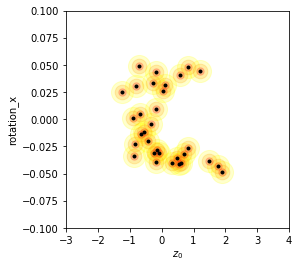

latent_dimension 1: 0.037472382


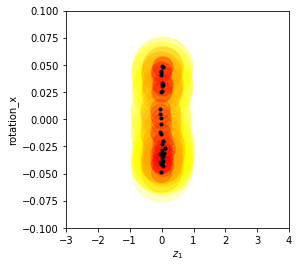

latent_dimension 2: 1.7349203


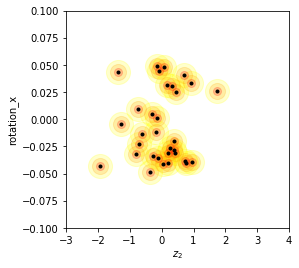

latent_dimension 3: 2.0313854


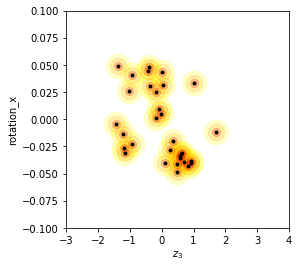

latent_dimension 4: 2.5317523


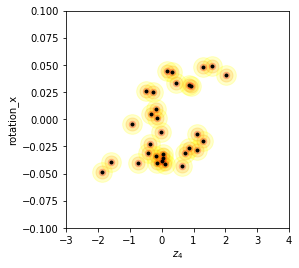

latent_dimension 5: 1.6395985


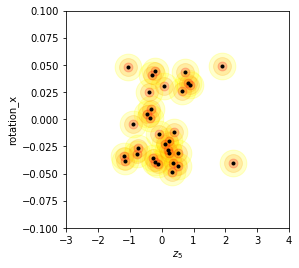

latent_dimension 6: 0.15273568


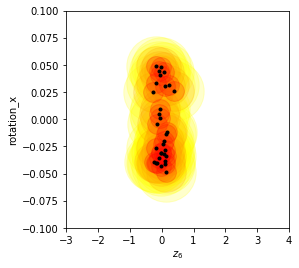

latent_dimension 7: 4.1295967


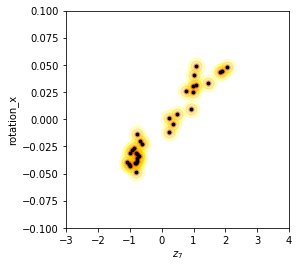

In [5]:
def plot_latent(dim, prop='m', show=False):
    c3s = []
    c2s = []
    c1s = []
    plt.figure(figsize=(4, 4))
    p_min = np.inf
    p_max = -np.inf
    σ = np.exp(latent_mapping.std_logits[0, dim].detach().cpu().numpy()) ** 0.5
    µs = []
    for i, env in enumerate(envs.envs):
        p, µ = (getattr(env, prop), latent_mapping.mean[i, dim].detach().cpu().numpy())
        µs.append(µ)
        plt.plot(µ, p, 'k.', markersize=σ * 150.0, color='yellow', alpha=0.2)
    for i, env in enumerate(envs.envs):
        p, µ = (getattr(env, prop), latent_mapping.mean[i, dim].detach().cpu().numpy())
        plt.plot(µ, p, 'k.', markersize=σ * 100.0, color='orange', alpha=0.2)
    for i, env in enumerate(envs.envs):
        p, µ = (getattr(env, prop), latent_mapping.mean[i, dim].detach().cpu().numpy())
        plt.plot(µ, p, 'k.', markersize=σ * 50.0, color='red', alpha=0.2)
    for i, env in enumerate(envs.envs):
        p, µ = (getattr(env, prop), latent_mapping.mean[i, dim].detach().cpu().numpy())
        p_min = min(p_min, p)
        p_max = max(p_max, p)
        plt.plot(µ, p, 'k.')
        
    # signal to noise
    µs = np.array(µs)
    print(f'latent_dimension {dim}:', (abs(µs) / σ).mean())
    
    plt.ylabel(prop)
    plt.xlabel(f'$z_{dim}$')
    plt.xlim(-3, 4)
    if prop == 'm':
        plt.ylim(-1, 2)
    elif prop == 'action_cost':
        plt.ylim(-0.5, 2.5)
    elif prop == 'rotation_x':
        plt.ylim(-0.1, 0.1)
    if show:
        plt.show()
    else:
        fig = plt.gcf()
        fig.canvas.draw()
        plot_img = np.array(fig.canvas.renderer._renderer)
        plt.close()
        return plot_img

Q.eval()
Q_target.eval()
latent_mapping_target.eval()
norm_q.eval()

for dim in range(8):
    plot_latent(dim, prop='rotation_x', show=True)

## Train

In [ ]:
likelihood_weight = 10.0
kl_weight = 0.001

def validate():
    i, x, u, u_opt, r, x_, u_ = next(iter(dataloader_val))
    if torch.cuda.is_available:
        i, x, u, u_opt, r, x_, u_ = map(lambda x: x.cuda(),
                                        (i, x.float(), u.float(), u_opt.float(), r.float(), x_.float(), u_.float()))

    z, kl = latent_mapping(i, deterministic=True)
    v_unnorm = Q_target(x_, u_, z)
    v_ = norm_q(v_unnorm)
    q_target = (r + gamma * v_)
    q_loss = norm_q.mse_loss(Q(x, u, z), q_target.detach())

    log_likelihood = -likelihood_weight * q_loss
    elbo = log_likelihood - kl_weight * kl.mean()
    return elbo

In [ ]:
Q.train()
norm_q.train()
latent_mapping.train()

r_max = -np.inf
r_min = np.inf
best_val = -np.inf

n_steps = -1
while True:
    for i, x, u, u_opt, r, x_, u_ in dataloader:
        n_steps += 1
        
        r_min = min(r_min, r.min())
        r_max = max(r_max, r.max())
        
        # Manual bootstrap
        # - Nothing atm
        
        # Data admin
        if torch.cuda.is_available:
            i, x, u, u_opt, r, x_, u_ = map(lambda x: x.cuda(),
                                            (i, x.float(), u.float(), u_opt.float(), r.float(), x_.float(), u_.float()))
        
        # Targets
        z_rand, kl = latent_mapping(i)
        z_det, _ = latent_mapping(i, deterministic=True)
        v_unnorm = Q_target(x_, u_, z_det)
        v_ = norm_q(v_unnorm)
        q_target = (r + gamma * v_).clamp(r_min / (1 - gamma), r_max / (1 - gamma))
        # Manual bootstrap
        # - Nothing atm
        q_loss = norm_q.mse_loss(Q(x, u, z_rand), q_target.detach())

        log_likelihood = -likelihood_weight * q_loss
        elbo = log_likelihood - kl_weight * variational_warmup(n_steps) * kl.mean()
        
        Q_opt.zero_grad()
        Z_opt.zero_grad()
        (-elbo).backward()
        Q_opt.step()
        Z_opt.step()
        
        soft_update(Q_target, Q, 0.001)
        soft_update(latent_mapping_target, latent_mapping, 0.001)
        
        if n_steps % 1000 == 0:
            #logger.add_image('v_3', plot_v(env_id=3), n_steps)
            #logger.add_image('v_4', plot_v(env_id=4), n_steps)
            #logger.add_image('q_0', plot_q(state=[0.0, 0.0]), n_steps)
            #logger.add_image('q_1', plot_q(state=[0.6, 0.0]), n_steps)
            #logger.add_image('q_-1', plot_q(state=[-0.6, 0.0]), n_steps)
            for i in range(z_size):
                logger.add_image(f'latent_{i}_x', plot_latent(i, prop='rotation_x'), n_steps)
        if n_steps % 100 == 0:
            logger.add_scalar('v_mean', v_unnorm.mean(), n_steps)
            logger.add_scalar('kl', kl.mean(), n_steps)
            logger.add_scalar('ll', log_likelihood, n_steps)
            logger.add_scalar('vσ', norm_q.σ, n_steps)
            logger.add_scalar('vµ', norm_q.µ, n_steps)
            logger.add_scalar('elbo', elbo, n_steps)
            val = validate()
            logger_val.add_scalar('elbo', val, n_steps)
            if val > best_val:
                best_val = val
                torch.save(latent_mapping.state_dict(), 'models/pushing/latent_mapping.pt')
                torch.save(latent_mapping_target.state_dict(), 'models/pushing/latent_mapping_target.pt')
                torch.save(norm_q.state_dict(), 'models/pushing/norm_q.pt')
                torch.save(Q.state_dict(), 'models/pushing/Q.pt')
                torch.save(Q_target.state_dict(), 'models/pushing/Q_target.pt')
        if n_steps >= 1000000:
            break
    if n_steps >= 1000000:
        break

In [ ]:
next(iter(dataloader))[2].max().numpy()

In [50]:
def evaluate(z, envs, env_index, use_optimal_policy=False, integrate_z=False, n_trials=16, rollout_len=100, render=False):
    is_training = policy.training
    policy.eval()
    if use_optimal_policy and integrate_z:
        raise ValueError('Cannot integrate over z when using teacher policy!')
    env = envs.envs[env_index]
    optimal_policy = envs.policies[env_index]
    z = torch.cuda.FloatTensor(z.reshape(1, -1))
    Rs = []
    np.random.seed(1)
    for _ in range(n_trials):
        if integrate_z:
            z = torch.randn(1, z_size).cuda()
        obs = env.reset()

        R = 0.0
        for t in range(rollout_len):
            x = torch.cuda.FloatTensor(obs.reshape(1, -1)).cuda()
            if use_optimal_policy:
                u_np = optimal_policy.act(obs)
            else:
                u = policy(x, z)
                u_np = u.detach().cpu().numpy().flatten() * env.action_space.high
            obs, r, _, _ = env.step(u_np)
            if render:
                env.render()
            R += r * gamma ** t

        Rs.append(R)
    if is_training:
        policy.train()
    return np.mean(Rs), np.std(Rs) / np.sqrt(n_trials)

env_id = 2
z = latent_mapping.mean[env_id].detach().cpu().numpy()
print(evaluate(z, envs, env_id, render=True, n_trials=4, use_optimal_policy=False))

(308.6388150781676, 15.383186886457224)


In [28]:
logger = SummaryWriter('runs/policy_training_pushing')

policy = Policy(x_size, u_size, z_size)
best_policy_score = -np.inf

Q.eval()
latent_mapping.cuda()
latent_mapping.eval()
policy.cuda()
policy.train()
policy_opt = torch.optim.Adam(policy.parameters())

n_steps = -1
while True:
    for i, x, u, u_opt, r, x_, u_ in dataloader:
        n_steps += 1
        
        # Data admin
        if torch.cuda.is_available:
            i, x, u, u_opt, r, x_, u_ = map(lambda x: x.cuda(),
                                            (i, x.float(), u.float(), u_opt.float(), r.float(), x_.float(), u_.float()))

        z_rand, kl = latent_mapping(i)
        u_policy = policy(x, z_rand)
        policy_loss = -norm_q(Q_target(x, u_policy, z_rand)).mean()
        policy_opt.zero_grad()
        policy_loss.backward()
        policy_opt.step()
        if n_steps % 100 == 0:
            logger.add_scalar('policy_loss', policy_loss, n_steps)
        if n_steps % 1000 == 0:
            return_avg = 0.0
            for i in range(len(envs)):
                z = latent_mapping.mean[i].detach().cpu().numpy()
                mean, std = evaluate(z, envs, i, n_trials=4)
                return_avg += mean / len(envs)
            logger.add_scalar('return_avg', return_avg, n_steps)
            if return_avg > best_policy_score:
                best_policy_score = return_avg
                torch.save(policy.state_dict(), 'models/pushing/policy.pt')
        if n_steps >= 1000000:
            break
    if n_steps >= 1000000:
        break

KeyboardInterrupt: 

In [7]:
policy.eval()
policy.load_state_dict(torch.load('models/pushing/policy.pt'))

In [14]:
x = torch.cuda.FloatTensor([[0.0, -0.2, 0.0, 0.0, 0.0, 0.1, 0.0]])
z = torch.cuda.FloatTensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
policy(x, z)

tensor([[-0.9999,  1.0000]], device='cuda:0')

In [ ]:
for env_index in range(4):
    print(f'Environment: {env_index}')
    # Found latent parameters (GD)
    val_trials = 1000
    z1, z2 = latent_mapping_test.mean[env_index, [0, 3]].cpu().detach().numpy()
    print('Evaluating gradient descent', end=' ')
    gd_µ, gd_σ = evaluate(z1, z2, envs, env_index, use_optimal_policy=False, n_trials=val_trials, integrate_z=False)
    print(gd_µ - 1.96 * gd_σ, gd_µ + 1.96 * gd_σ)
    
    print('Evaluating average policy', end=' ')
    int_z_µ, int_z_σ = evaluate(0, 0, envs, env_index, n_trials=val_trials, integrate_z=True)
    print(int_z_µ - 1.96 * int_z_σ, int_z_µ + 1.96 * int_z_σ)
    
    print('Evaluating teacher policy', end=' ')
    optimal_µ, optimal_σ = evaluate(0, 0, envs, env_index, use_optimal_policy=True, n_trials=val_trials, integrate_z=False)
    print(optimal_µ - 1.96 * optimal_σ, optimal_µ + 1.96 * optimal_σ)
    
    bo = bayes_opt.BayesianOptimization(lambda z1, z2: evaluate(z1, z2, envs, env_index, n_trials=4)[0],
                                        {'z1': (-2, 2), 'z2': (-2, 2)})
    bo.maximize(init_points=5, n_iter=15, **{'alpha': 1e-3})
    z1, z2 = bo.res['max']['max_params'].values()
    bo_return_µ, bo_return_σ = evaluate(z1, z2, envs, env_index, use_optimal_policy=False, n_trials=val_trials, integrate_z=False)
    print(f'Average policy: {int_z_µ:.1f} +- {int_z_σ:.1f}\n' +
          f'Teacher policy: {optimal_µ:.1f} +- {optimal_σ:.1f}\n' +
          f'Gradient descent: {gd_µ:.1f} +- {gd_σ:.1f}\n' +
          f'20-step BO: {bo_return_µ:.1f} +- {bo_return_σ:.1f}')

In [ ]:
for env_index in range(4):
    opt_return = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=True)
    print(f'Environment: {env_index}')
    bo = bayes_opt.BayesianOptimization(lambda z1, z2: evaluate(z1, z2, envs_test, env_index),
                                        {'z1': (-2, 2), 'z2': (-2, 2)})
    bo.maximize(init_points=20, n_iter=20, **{'alpha': 1e-3})
    z1, z2 = bo.res['max']['max_params'].values()
    int_z = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=False, n_trials=128, integrate_z=True)
    optimal = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=True, n_trials=128, integrate_z=False)
    bo_return = evaluate(z1, z2, envs_test, env_index, use_optimal_policy=False, n_trials=128, integrate_z=False)
    print(f'Average policy: {int_z} Teacher policy: {optimal} 20-BO: {bo_return}')

In [ ]:
z1, z2 = bo.res['max']['max_params'].values()
evaluate(z1, z2, envs_test, 0, use_optimal_policy=True)

In [ ]:
env = envs.envs[0]

In [9]:
xs_ = []
coeffs = []
for i, env in enumerate(envs.envs):
    xs_.append((env.rotation_x, i))

z1s_x = []
z2s_x = []
xs = []
for x, i in sorted(xs_):
    z1 = latent_mapping.mean[i, 4].cpu().detach().numpy()
    z2 = latent_mapping.mean[i, 7].cpu().detach().numpy()
    xs.append(x)
    z1s_x.append(z1)
    z2s_x.append(z2)
latent_mapping.std_logits

Parameter containing:
tensor([[-2.4454, -0.4687, -2.2726, -2.2560, -2.6793, -2.0597, -0.4651,
         -2.9920]], device='cuda:0')

<IPython.core.display.Javascript object>


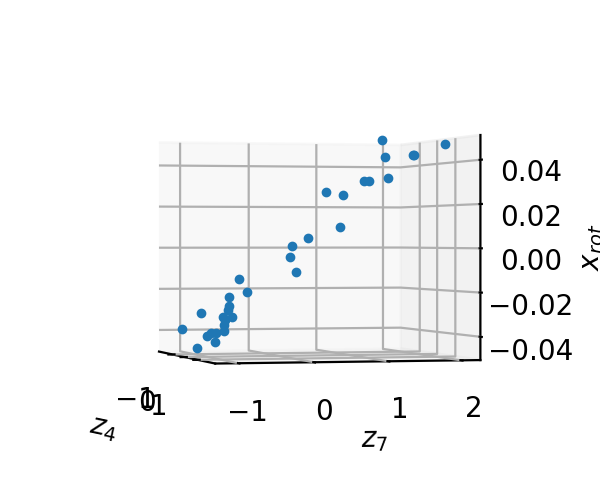

In [28]:
latent_mapping.eval()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(z1s_x, z2s_x, xs, '.', markersize=5.0)
ax.set_xlabel('$z_4$')
ax.set_ylabel('$z_7$')
ax.set_zlabel('$x_{rot}$')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1, 2])
ax.grid(True)
ax.axis('on')
#ax.set_zticks([0.0, 0.5, 1.0])
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
ax.view_init(elev=3, azim=-12)
plt.savefig('rotation_x_latent.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(z2s_k, z1s_k, ks, '.', markersize=5.0)
ax.plot(z2s_k, z1s_k, np.zeros(len(ms)), '.', color='grey', alpha=0.2)
ax.set_xlabel('$z_3$')
ax.set_ylabel('$z_0$')
ax.set_zlabel('$k$')
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_zticks([0.0, 1.0, 2.0])
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.view_init(elev=10, azim=118)
plt.show()

In [ ]:
def plot(azimuth, filename=None):
    fig = plt.figure(figsize=(3, 2.5))
    #fig = plt.figure(figsize=(9, 7.5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(z1s_m, z2s_m, (np.array(ms) - 0.4) * 1.3, '.', markersize=5.0)
    ax.plot(z1s_k, z2s_k, np.array(ks) * 0.5, '.', markersize=5.0)
    ax.plot(z1s_k, z2s_k, np.zeros(len(ms)), '.', color='grey', alpha=0.1, markersize=5.0)
    ax.set_xlabel('$z_0$')
    ax.set_ylabel('$z_3$')
    ax.set_zlabel('$k_n$')
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    ax.set_zticks([0.0, 1.0])
    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_zticks([])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.view_init(elev=4, azim=-35 + azimuth)
    ax.quiver(-2, -2, 0, 2, 0, 0, arrow_length_ratio=0.0, color='red')
    ax.quiver(-2, -2, 0, 0, 2, 0, arrow_length_ratio=0.0, color='green')
    ax.quiver(-2, -2, 0, 0, 0, 0.4, arrow_length_ratio=0.0, color='blue')
    ax.grid(True)
    ax.axis('on')
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
for ind, i in enumerate([0, 30, 60, 90]):
    print(ind, i)
    #plot(i)
    plot(i)

In [ ]:
% matplotlib inline
from sklearn.decomposition import PCA

pca = PCA()
X = latent_mapping.mean.detach().cpu().numpy()
Y = X - X.mean(axis=1, keepdims=True)
plt.imshow(Y.T @ Y)
plt.show()

pca.fit(X)
X_ = (pca.components_@ X.T).T
Y_ = X_ - X_.mean(axis=1, keepdims=True)
plt.imshow(Y_.T @ Y_)
plt.colorbar()
plt.show()